# Text to Query

Given a sentence, can we tag it to entities that reference fields in the database

Heres a schema loaded from a postgres database

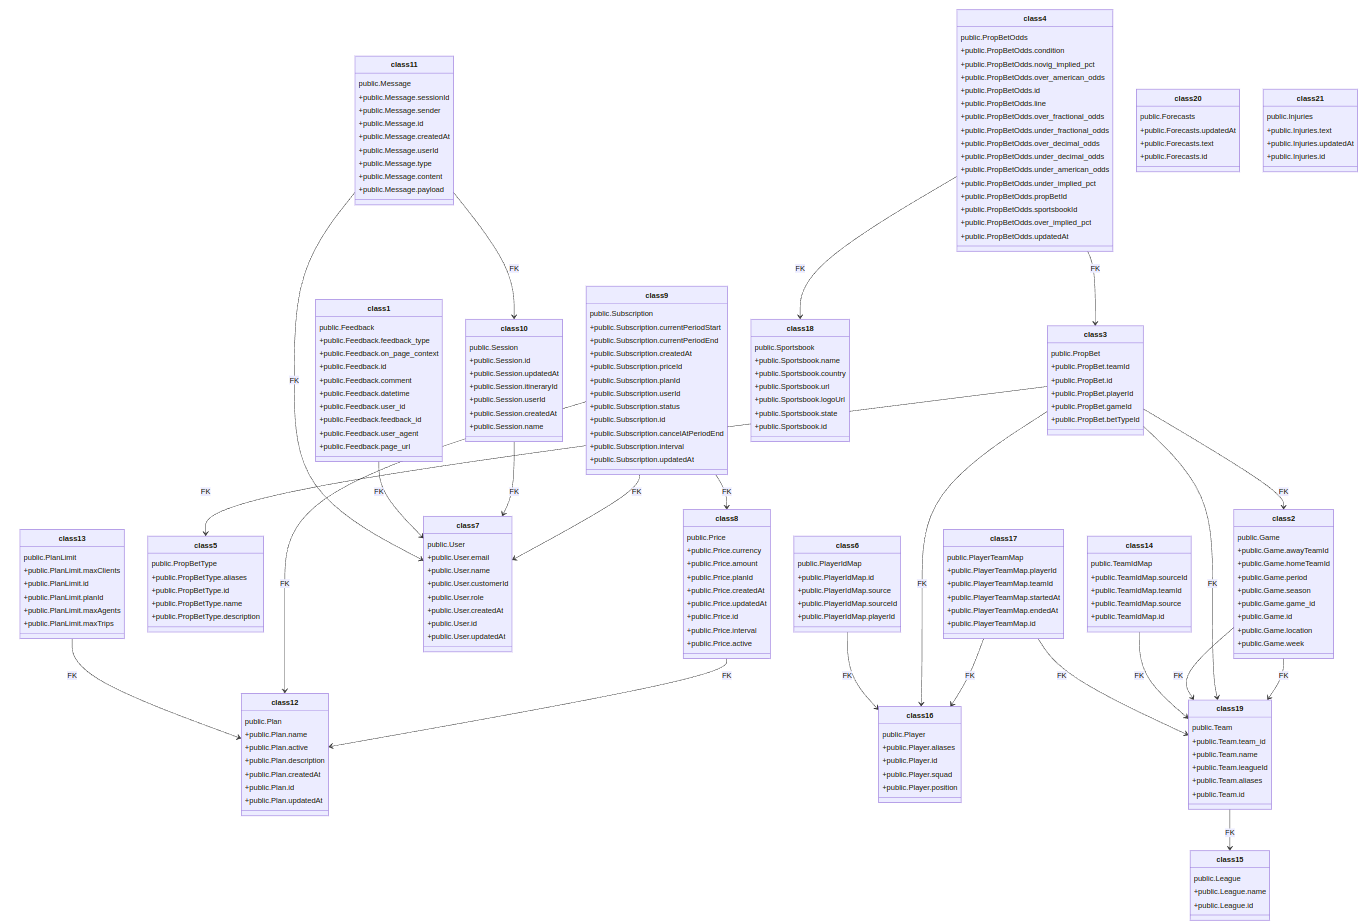

In [1]:
query = "Who's on the patriots defense?"

In [4]:
from promptedgraphs.sources.datagraph_from_postgres import db_connect, load_schema_graph, generate_mermaid_diagram

conn = db_connect()
G = load_schema_graph(
    conn, schema="public", exclude_nodes=["public._prisma_migrations", "public.Otp"]
)

DETAIL:  The database was created using collation version 2.31, but the operating system provides version 2.36.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE chattcl_webapp REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


In [5]:
mermaid_diagram = generate_mermaid_diagram(G)
print(mermaid_diagram)

classDiagram
    class1 : public.Feedback
    class2 : public.Game
    class3 : public.PropBet
    class4 : public.PropBetOdds
    class5 : public.PropBetType
    class6 : public.PlayerIdMap
    class7 : public.User
    class8 : public.Price
    class9 : public.Subscription
    class10 : public.Session
    class11 : public.Message
    class12 : public.Plan
    class13 : public.PlanLimit
    class14 : public.TeamIdMap
    class15 : public.League
    class16 : public.Player
    class17 : public.PlayerTeamMap
    class18 : public.Sportsbook
    class19 : public.Team
    class20 : public.Forecasts
    class21 : public.Injuries
    class7 : +public.User.email
    class16 : +public.Player.aliases
    class2 : +public.Game.awayTeamId
    class19 : +public.Team.team_id
    class3 : +public.PropBet.teamId
    class8 : +public.Price.currency
    class9 : +public.Subscription.currentPeriodStart
    class10 : +public.Session.id
    class8 : +public.Price.amount
    class15 : +public.League.name
  

In [34]:
from fuzzywuzzy import process
import psycopg2  # or any other database library you're using

# Database connection (example using psycopg2 for PostgreSQL)
conn = db_connect()

cur = conn.cursor()

# Step 1: Query Database for Team Names
cur.execute("SELECT id, name FROM \"Team\";")
teams = cur.fetchall()

# Step 2: Use FuzzyWuzzy to match "Patriots"
team_names = [team[1] for team in teams]
matched_team_name = process.extractOne("Patriots", team_names)[0]

matched_team_name

DETAIL:  The database was created using collation version 2.31, but the operating system provides version 2.36.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE chattcl_webapp REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


'New England Patriots'

In [35]:
# Find the team ID for the matched team name
matched_team_id = next(team[0] for team in teams if team[1] == matched_team_name)
matched_team_id

'clpvu87ht0009dhfnhncubhlj'

In [36]:

# Step 4: Query for Unique Player Positions
cur.execute("SELECT DISTINCT position FROM public.\"Player\";")
positions = cur.fetchall()
unique_positions = [position[0] for position in positions]
unique_positions

['WR', 'RB', 'QB', 'TE', 'K', None]

In [37]:
# Step 4: Query for Defensive Players on the Team
# Adjust the SQL query based on your database's specific way to identify defensive positions
cur.execute("""
SELECT \"Player\".id, \"Player\".name, \"Player\".position 
FROM \"Player\"
JOIN \"PlayerTeamMap\" ON \"Player\".id = \"PlayerTeamMap\".\"playerId\"
WHERE \"PlayerTeamMap\".\"teamId\" = %s;
""", (matched_team_id,))

defensive_players = cur.fetchall()

# Close the database connection
cur.close()
conn.close()

# Print or process the defensive players information
for player in defensive_players:
    print(player)

('a4f02f3b-0486-4b48-ba2e-b23c2adeb0c4', 'bailey zappe', 'QB')
('2ec637fc-4d51-4f92-9e6f-046bc3f99985', 'demario douglas', 'WR')
('89d22aab-7574-4a28-a52d-b22e28dadecd', 'devante parker', 'WR')
('779016e3-2d81-4f65-9a4d-f5ccf89988d9', 'ezekiel elliott', 'RB')
('b78b4d75-b2c0-41ed-a931-be2b6a16153b', 'hunter henry', 'TE')
('dedcbc59-4308-4d70-a1ac-cc2074a5ce80', 'jalen reagor', 'WR')
('231fdb27-3637-49af-9af3-34aa1ca358bd', 'juju smith schuster', None)
('dc25369d-652d-4a29-9dea-de305a80e7c8', 'kendrick bourne', 'WR')
('075a5bf5-0afd-4e86-be27-24749f740908', 'mac jones', 'QB')
('96724db9-2052-4659-ae54-4af7dfa0e62b', 'mike gesicki', 'TE')
('f908da36-6360-4faa-a915-0f2469e8891f', 'rhamondre stevenson', 'RB')
('3761dc0a-048e-4cad-967a-870a17445339', 'tyquan thornton', 'WR')


In [46]:
from transformers import BartTokenizer, BartModel
import torch
from scipy.spatial.distance import cosine

# Initialize BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartModel.from_pretrained('facebook/bart-large')

# Replace the example unique positions with the actual ones from your query
# unique_positions = ['Quarterback', 'Linebacker', 'Safety', 'Wide Receiver', 'Cornerback', 'Defensive End']

# Encode "defense" and the unique positions for comparison
texts = ["defense"] + [t for t in unique_positions if t]
encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Generate embeddings
with torch.no_grad():
    model_output = model(**encoded_input)
    embeddings = model_output.last_hidden_state
    # averaged_embeddings = torch.mean(embeddings, dim=1)  
    embeddings = model_output.last_hidden_state[:, 0, :]  # Taking the output of the [CLS] token

# Calculate cosine similarity between "defense" and each position
defense_embedding = embeddings[0]
cosine_similarities = [1 - cosine(defense_embedding, embedding) for embedding in embeddings[1:]]

# Pair each position with its similarity score
position_similarity = list(zip(unique_positions, cosine_similarities))

# Display or process the similarity scores
for position, similarity in position_similarity:
    print(f"{position}: {similarity}")


Quarterback (QB): 0.7607827986670257
Running Back (RB): 0.7718717438393748
Fullback (FB): 0.7507465925523035
Wide Receiver (WR): 0.7400572880553509
Tight End (TE): 0.7858049955450014
Offensive Lineman (OL): 0.7039430293841792
Center (C): 0.79193262828191
Guard (G): 0.7059990663598049
Tackle (T): 0.8062816786353906
Defensive Lineman (DL): 0.7484225786435962
Defensive End (DE): 0.7559478431625546
Defensive Tackle (DT): 0.7611426315444825
Linebacker (LB): 0.7538476571783256
Outside Linebacker (OLB): 0.7038653686494081
Inside Linebacker (ILB): 0.7675417807318397
Defensive Back (DB): 0.7543979504575586
Cornerback (CB): 0.7634074931014522
Safety (S): 0.7929287954843155
Free Safety (FS): 0.7461139126212792
Strong Safety (SS): 0.7310668925526386
Kicker (K): 0.7829985562308952
Punter (P): 0.7722254312953548
Long Snapper (LS): 0.7701693508826384
Holder (H): 0.8006105072593604
Kick Returner (KR): 0.7496102911092023
Punt Returner (PR): 0.7786807519184948
Gunners: 0.7617094652806867


In [53]:

ansert = {"Defensive Lineman (DL)",
    "Defensive End (DE)",
    "Defensive Tackle (DT)",
    "Linebacker (LB)",
    "Outside Linebacker (OLB)",
    "Inside Linebacker (ILB)",
    "Defensive Back (DB)",
    "Cornerback (CB)",
    "Safety (S)",
    "Free Safety (FS)",
    "Strong Safety (SS)"}
import pandas as pd
pd.DataFrame(
    [i[0], "Y" if i[0] in ansert else "", i[1]]
    for i in sorted(position_similarity, key=lambda x: x[1])
)

,0,1,2
0,Outside Linebacker (OLB),Y,0.703865
1,Offensive Lineman (OL),,0.703943
2,Guard (G),,0.705999
3,Strong Safety (SS),Y,0.731067
4,Wide Receiver (WR),,0.740057
5,Free Safety (FS),Y,0.746114
6,Defensive Lineman (DL),Y,0.748423
7,Kick Returner (KR),,0.749610
8,Fullback (FB),,0.750747
9,Linebacker (LB),Y,0.753848


In [45]:
unique_positions = ["Quarterback (QB)",
    "Running Back (RB)",
    "Fullback (FB)",
    "Wide Receiver (WR)",
    "Tight End (TE)",
    "Offensive Lineman (OL)",
    "Center (C)",
    "Guard (G)",
    "Tackle (T)",
    "Defensive Lineman (DL)",
    "Defensive End (DE)",
    "Defensive Tackle (DT)",
    "Linebacker (LB)",
    "Outside Linebacker (OLB)",
    "Inside Linebacker (ILB)",
    "Defensive Back (DB)",
    "Cornerback (CB)",
    "Safety (S)",
    "Free Safety (FS)",
    "Strong Safety (SS)",
    "Kicker (K)",
    "Punter (P)",
    "Long Snapper (LS)",
    "Holder (H)",
    "Kick Returner (KR)",
    "Punt Returner (PR)",
    "Gunners"
  ]
